# CAPSTONE
Kehinde Ajayi

Initial modeling

In [1]:
# from google.colab import auth
# auth.authenticate_user()

# # https://cloud.google.com/resource-manager/docs/creating-managing-projects
# project_id = 'capstone2022-349201'

In [2]:
## check if notebook is running on Colab--if so, run appropriate installs and mount Google Drive
# https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab

if 'google.colab' in str(get_ipython()):
  # install RDKit and DeepChem
  !pip install rdkit-pypi --pre deepchem git+https://github.com/PatWalters/clusterama.git dgl-cu113 dglgo -f https://data.dgl.ai/wheels/repo.html dgllife torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
  # mount Google Drive
  from google.colab import drive
  drive.mount('/content/drive')
  !pip install --upgrade matplotlib

In [3]:
!pwd


/home/xohdeeacque/flex/Capstone/ka_capstone/notebooks


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML

import sys

from tqdm.auto import tqdm

from rdkit.Chem import PandasTools

import deepchem as dc
import tensorflow as tf
from deepchem.models import GATModel, GCNModel
from deepchem.models.layers import GraphConv, GraphPool, GraphGather

In [2]:
tf.config.list_physical_devices('GPU')

2022-07-20 03:37:05.001594: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-20 03:37:05.001682: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


[]

## Functions and settings

In [3]:
# workaround for bug where molecular structure does not print with dataframe
# https://github.com/rdkit/rdkit/issues/2673
def show(df):
    return HTML(df.to_html(notebook=True))


In [4]:
# check if notebook is running on Colab and set path for data file 

def get_home_path():
  if 'google.colab' in str(get_ipython()):
    file_path = '/content/drive/MyDrive/GA/Capstone/ka_capstone'
  else:
    file_path = '..'
  
  return file_path


In [5]:
# GAT model

def generate_gat_model(model_num, gat_layers=[64,64], batch_size=128, learning_rate=0.001):
    """Instantiates a Graph Convolution model.

    Args:
        param1: The first parameter.
        param2: The second parameter.

    Returns:
        The return value. True for success, False otherwise.

    """
    model = GATModel(mode='classification',
                      n_tasks=1,
                      graph_attention_layers=gat_layers,
                      batch_size=batch_size,
                      learning_rate=learning_rate,
                      model_dir=f'{get_home_path()}/models/gat_model_{model_num}')
    
    return model

In [6]:
# view all columns in dataframe
pd.set_option('display.max.columns', None)

## Read data

In [10]:
    
# read hERG data into dataframe 
herg_df = pd.read_csv(f'{get_home_path()}/data/interim/herg_data_sample.csv')


In [11]:

herg_df.head()

,Pubchem_SID,SMILES,hERG_at_1uM,hERG_at_10uM,herg_inhibitor,mw,logP,PSA,H_bond_donors,H_bond_acceptors,num_heteroatoms,total_num_rings,aromatic_rings,num_rotatable_bonds,num_stereocenters,formal_charge,SMILES_length,ro5_violations,adjacency_matrix,label
0,24788014,O=C(O)C1CSC(c2ccco2)N1,11.1661,5.11118,0,199.231,1.06780,62.47,2,4,5,2,1,2,2,0,22,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0]\n [1 0 1 1 0 0 0 ...,inactive
1,14721353,CCc1cc2c(SCC(=O)c3ccc(C)cc3)ncnc2s1,14.7770,9.64508,0,328.462,4.53712,42.85,0,5,5,3,3,5,0,0,35,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]...,inactive
2,14745786,COc1cc(-c2nnc(SCC(=O)Nc3ccc4c(c3)OCCO4)o2)cc(O...,5.5134,4.74908,0,459.480,3.26440,114.17,1,10,11,4,3,8,0,0,52,0,[[0 1 0 ... 0 0 0]\n [1 0 1 ... 0 0 0]\n [0 1 ...,inactive
3,57266348,CC(OC(=O)c1ccc2c(=O)n3c(nc2c1)CCC3)C(=O)Nc1ccc...,6.1738,7.79268,0,420.425,1.62560,133.38,2,7,9,4,3,5,1,0,57,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,inactive
4,47202451,CCCCCn1c(=O)c(C(=O)Nc2ccccc2N)c(O)c2ccccc21,15.3279,21.42188,0,365.433,3.73180,97.35,3,5,6,3,3,6,0,0,43,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,inactive


## Create dataset for Graph Attentional NN


**From Veličković:**  






Model for Graph Property Prediction Based on Graph Attention Networks (GAT).

This model proceeds as follows:

Update node representations in graphs with a variant of GAT

For each graph, compute its representation by 1) a weighted sum of the node representations in the graph, where the weights are computed by applying a gating function to the node representations 2) a max pooling of the node representations 3) concatenating the output of 1) and 2)

Perform the final prediction using an MLP

MolGraphConvFeaturizer
classMolGraphConvFeaturizer(use_edges: bool = False, use_chirality: bool = False, use_partial_charge: bool = False)[source]
This class is a featurizer of general graph convolution networks for molecules.

The default node(atom) and edge(bond) representations are based on WeaveNet paper. If you want to use your own representations, you could use this class as a guide to define your original Featurizer. In many cases, it’s enough to modify return values of construct_atom_feature or construct_bond_feature.

The default node representation are constructed by concatenating the following values, and the feature length is 30.

Atom type: A one-hot vector of this atom, “C”, “N”, “O”, “F”, “P”, “S”, “Cl”, “Br”, “I”, “other atoms”.

Formal charge: Integer electronic charge.

Hybridization: A one-hot vector of “sp”, “sp2”, “sp3”.

Hydrogen bonding: A one-hot vector of whether this atom is a hydrogen bond donor or acceptor.

Aromatic: A one-hot vector of whether the atom belongs to an aromatic ring.

Degree: A one-hot vector of the degree (0-5) of this atom.

Number of Hydrogens: A one-hot vector of the number of hydrogens (0-4) that this atom connected.

Chirality: A one-hot vector of the chirality, “R” or “S”. (Optional)

Partial charge: Calculated partial charge. (Optional)

The default edge representation are constructed by concatenating the following values, and the feature length is 11.

Bond type: A one-hot vector of the bond type, “single”, “double”, “triple”, or “aromatic”.

Same ring: A one-hot vector of whether the atoms in the pair are in the same ring.

Conjugated: A one-hot vector of whether this bond is conjugated or not.

Stereo: A one-hot vector of the stereo configuration of a bond.

If you want to know more details about features, please check the paper [1]_ and utilities in deepchem.utils.molecule_feature_utils.py.

In [8]:
## load dataset if it exists and create it if it doesn't
try:
    # load saved dataset
    dataset = dc.data.DiskDataset(f'{get_home_path()}/data/processed/GATFeatures')
except ValueError:
    # create dataset
    dataset_file = f'{get_home_path()}/data/interim/herg_data.csv'
    tasks = ['herg_inhibitor']
    featurizer = dc.feat.MolGraphConvFeaturizer()
    loader = dc.data.CSVLoader(tasks=tasks,
                               feature_field='SMILES',
                               featurizer=featurizer)
    dataset = loader.create_dataset(dataset_file, f'{get_home_path()}/data/processed/GATFeatures', shard_size=8192)

In [13]:
# split dataset into training, validation, and testing sets
splitter = dc.splits.RandomStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

In [14]:
print(dataset)

<DiskDataset X.shape: (30689,), y.shape: (30689, 1), w.shape: (30689, 1), task_names: ['herg_inhibitor']>


In [15]:
type(dataset.y)

numpy.ndarray

In [16]:
# dc.utils.data_utils.save_to_disk(dataset, filename='../data/processed/deepchem_dataset')

In [16]:
# define metrics used to evaluate model
metrics = [dc.metrics.Metric(dc.metrics.matthews_corrcoef, np.mean, mode='classification'), dc.metrics.Metric(dc.metrics.accuracy_score, np.mean, mode='classification'), dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode='classification')]

In [17]:
dataset.data_dir

'../data/processed/GATFeatures'

In [18]:
# Inspect features for molecule 0
conv_feature = train_dataset.X[4]
# Print the atom features
print(conv_feature.node_features)
# Print the adjacency list
# print(conv_feature.get_adjancency_list())

[[1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [19]:
dir(conv_feature)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'edge_features',
 'edge_index',
 'node_features',
 'node_pos_features',
 'num_edges',
 'num_node_features',
 'num_nodes',
 'to_dgl_graph',
 'to_pyg_graph']

In [20]:
print(conv_feature.to_dgl_graph())

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
Graph(num_nodes=34, num_edges=72,
      ndata_schemes={'x': Scheme(shape=(30,), dtype=torch.float32)}
      edata_schemes={})


In [23]:
print(conv_feature.to_pyg_graph())

Data(x=[34, 30], edge_index=[2, 72])


In [24]:
print(len(herg_df.adjacency_matrix[4][1]))

1


In [25]:
conv_feature.node_features.shape


(34, 30)

In [26]:
print(conv_feature.edge_index)

[[ 0  7  7 26 26 19 19 27 27 28 28 11 11 12 28 15 15 31 31 22 22 29 22  3
  22 21 21 30 30 14 14 32 32 33 33  4  4 17  4 24 24  9  9  1  1  6  6 18
  18 16 16 23 16  2 16 20  6 13 13  8 32  5  5 25 15 10 10 26 25 21  8 24]
 [ 7  0 26  7 19 26 27 19 28 27 11 28 12 11 15 28 31 15 22 31 29 22  3 22
  21 22 30 21 14 30 32 14 33 32  4 33 17  4 24  4  9 24  1  9  6  1 18  6
  16 18 23 16  2 16 20 16 13  6  8 13  5 32 25  5 10 15 26 10 21 25 24  8]]


### Run models

In [27]:
# training_score_list = []
# validation_score_list = []
# transformers = []
# cv_folds = 5
# for i in range(0, cv_folds):
#   model = generate_gcnn_model()
#   train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
#   model.fit(train_dataset)
#   train_scores = model.evaluate(train_dataset,
#                                 metrics,
#                                 transformers)
#   training_score_list.append(train_scores["mean-matthews_corrcoef"])
#   validation_scores = model.evaluate(valid_dataset,
#                                      metrics,
#                                      transformers)
#   validation_score_list.append(validation_scores["mean-matthews_corrcoef"])
#   print(training_score_list)
#   print(validation_score_list)

## GAT model

In [29]:
# training model

model_num='01'
learning_rate=0.001
gat_layers=[128,256]

model_gat1 = generate_gat_model(model_num='01', gat_layers=[128,256], batch_size=128, learning_rate=0.001)




In [30]:
hist_gat1 = model_gat1.fit(train_dataset, nb_epoch=20)

/home/xohdeeacque/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [31]:
hist_gat1

0.025610214471817015

In [32]:
print('Training set score:', model_gat1.evaluate(train_dataset, metrics))
print('Validation set score:', model_gat1.evaluate(valid_dataset, metrics))
print('Test set score:', model_gat1.evaluate(test_dataset, metrics))

Training set score: {'mean-matthews_corrcoef': -0.0036575646229749397, 'mean-accuracy_score': 0.9549101869577614, 'mean-roc_auc_score': 0.8135257945968575}
Validation set score: {'mean-matthews_corrcoef': 0.0, 'mean-accuracy_score': 0.9553600521342457, 'mean-roc_auc_score': 0.7599157546728273}
Test set score: {'mean-matthews_corrcoef': -0.0039025692923979516, 'mean-accuracy_score': 0.9550342130987293, 'mean-roc_auc_score': 0.7840093207596022}


In [28]:
model_gat2 = generate_gat_model(model_num='02', gat_layers=[256,512], batch_size=128, learning_rate=0.001)

In [ ]:
hist_gat2 = model_gat2.fit(train_dataset, nb_epoch=20)

In [ ]:
print('Training set score:', model_gat2.evaluate(train_dataset, metrics))
print('Validation set score:', model_gat2.evaluate(valid_dataset, metrics))
print('Test set score:', model_gat2.evaluate(test_dataset, metrics))

In [ ]:
learning_rate19 = dc.models.optimizers.ExponentialDecay(0.001, 0.7, 1024)
save_dir19=f'{get_home_path()}/models/gcn_model_19'

model19 = GraphConvModel(1, batch_size=128,
                         dropout=0.0,
                         graph_conv_layers=[1024, 2048],
                         dense_layer_size=256,
                         mode='classification',
                         tensorboard=True,
                         learning_rate=learning_rate19,
                         model_dir=f'{get_home_path()}/models/gcn_model_19')
validation=dc.models.ValidationCallback(valid_dataset,
                                        1024,
                                        metrics,
                                        save_dir=f'{save_dir19}/callbacks',
                                        save_on_minimum=False)

Previous results (MCC):  
[0.4502412189462288]  
[0.4128819211180105]  
[0.4502412189462288, 0.4965585838893341]  
[0.4128819211180105, 0.4654923820863219]  
[0.4502412189462288, 0.4965585838893341, 0.5585299037933114]  
[0.4128819211180105, 0.4654923820863219, 0.45430324072314515]  
[0.4502412189462288, 0.4965585838893341, 0.5585299037933114, 0.6192709501522672]  
[0.4128819211180105, 0.4654923820863219, 0.45430324072314515, 0.5214770300289555]  
[0.4502412189462288, 0.4965585838893341, 0.5585299037933114, 0.6192709501522672, 0.5843172323482354]  
[0.4128819211180105, 0.4654923820863219, 0.45430324072314515, 0.5214770300289555, 0.49755690080208853]  

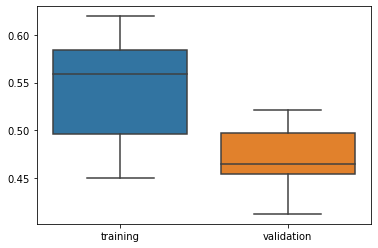

In [ ]:
## training vs validation MCC scores
sns.boxplot(x = ["training"] * cv_folds + ["validation"] * cv_folds, y = training_score_list + validation_score_list);

In [ ]:
pred = [x.flatten() for x in model.predict(valid_dataset)]

In [ ]:
pred_df = pd.DataFrame(pred,columns=["neg","pos"])

In [ ]:
pred_df["active"] = [int(x) for x in valid_dataset.y]
pred_df["SMILES"] = valid_dataset.ids

In [ ]:
pred_df.sample(5)

,neg,pos,active,SMILES
10191,0.998757,0.001243,0,CC1=C(C(=O)OCc2ccccc2)C(c2cccnc2)n2ncnc2N1
2610,0.999847,0.000153,0,CN(Cc1cccs1)C(=O)CNC(=O)c1ccco1
3003,0.952261,0.047739,1,N#C/C(=C\c1cccc([N+](=O)[O-])c1)C(=O)NCc1cccnc1
788,0.982654,0.017346,1,CCOc1ccc(C(=O)NCCCN(CC)CC)cc1
14071,0.995364,0.004636,0,CCCCCCCN(C(=O)CCl)c1cccc(C)c1


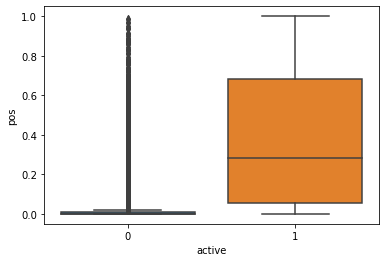

In [ ]:
# plot predicted probabilities for active and inactives
sns.boxplot(x=pred_df.active, y=pred_df.pos);

In [ ]:
# put false negatives in a new dataframe
false_negative_df = pred_df.query("active == 1 & pos < 0.5").copy()
PandasTools.AddMoleculeColumnToFrame(false_negative_df, 'SMILES', 'Mol')

In [ ]:
type(valid_dataset)

deepchem.data.datasets.DiskDataset

,neg,pos,active,SMILES,Mol
16849,0.652027,0.347973,1,COc1ccc(CNCCC(c2ccccc2)C2CCOC(C)(C)C2)cc1,
21014,0.920934,0.079066,1,c1ccc(C(c2ccccc2)c2noc(CN3CCN(CC4CC4)CC3)n2)cc1,
11563,0.622856,0.377144,1,COc1cc(CN2CCC(CCC(=O)NC3CC3)CC2)cc(Cl)c1OC,
11702,0.559105,0.440895,1,O=C(CN1CCN(Cc2ccc(Cl)cc2)CC1)N/N=C/c1ccncc1,
18031,0.692768,0.307232,1,C=CCN(c1ccccc1)S(=O)(=O)c1cccc(C(=O)NC2CCN(Cc3...,

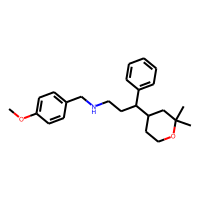
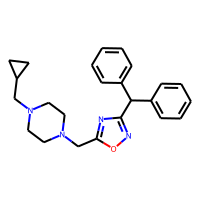
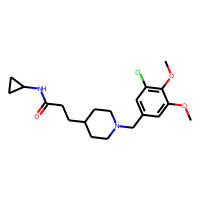
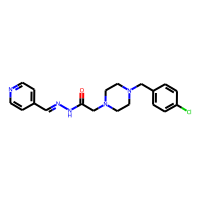
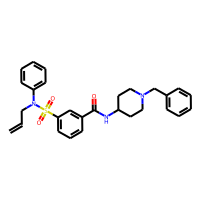

In [ ]:
show(false_negative_df.sample(5))

In [ ]:
false_positive_df = pred_df.query("active == 0 & pos > 0.5").copy()
PandasTools.AddMoleculeColumnToFrame(false_positive_df, 'SMILES', 'Mol')

,neg,pos,active,SMILES,Mol
23687,0.058787,0.941213,0,CCc1ccccc1NC(=O)CN1CCN(CC(=O)NCc2ccc(Cl)cc2)CC1,
6258,0.207830,0.792170,0,COc1ccc(F)cc1C(=O)C1CCCN(Cc2cn(C)c3ccccc23)C1,
5257,0.429260,0.570740,0,Cl.OC(COc1c(F)cc(Br)cc1F)CN1CCN(c2ccc(F)cc2)CC1,
21501,0.193804,0.806196,0,CCc1ccc(NC(=O)CSc2nc(=O)n(CCN(C)C)c3c2CCCC3)cc1,
9692,0.467457,0.532543,0,O=c1c2ccccc2nc(-c2ccccc2)n1CCCn1ccnc1,

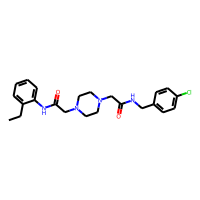
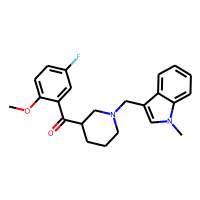
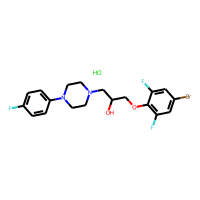
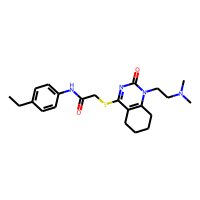
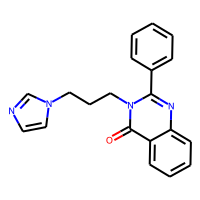

In [ ]:
show(false_positive_df.sample(5))

In [ ]:
false

In [ ]:
def conv_net():
  K.clear_session()
  weights = 'imagenet'
  inputs = Input(shape=(128, 128, 3))

  base_model = ResNet50(include_top=False, weights=weights, input_shape=(128, 128, 3))

  for layer in base_model.layers:
    layer.trainable = False

  x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(128, 128, 3))(inputs)
  x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

  x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

  x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

  x = Flatten()(x)

  base_resnet = base_model(inputs)
  base_resnet = Flatten()(base_resnet)

  concated_layers = Concatenate()([x, base_resnet])

  concated_layers = Dense(2024, activation='relu')(concated_layers)
  concated_layers = Dense(524, activation='relu')(concated_layers)
  concated_layers = Dense(124, activation='relu')(concated_layers)
  output = Dense(4, activation='relu')(concated_layers)

  model = Model(inputs=inputs, outputs=output)
  return model